In [1]:
import os
os.chdir('../../')

## GPU 设置

In [2]:
GPUID='0'##调用GPU序号
os.environ["CUDA_VISIBLE_DEVICES"] = GPUID

In [3]:
import numpy as np
import tensorflow as tf
from glob import glob
from PIL import Image
import cv2
Input =tf.keras.layers.Input
Lambda = tf.keras.layers.Lambda
load_model = tf.keras.models.load_model
Model = tf.keras.models.Model

from apphelper.image import get_box_spilt,read_voc_xml,resize_im,read_singLine_for_yolo
from text.keras_yolo3 import  preprocess_true_boxes, yolo_text
from train.text.utils import get_random_data_ as get_random_data


def data_generator(roots, anchors, num_classes,splitW):
    '''data generator for fit_generator
    @@roots:jpg/png
    '''
    n = len(roots)
    np.random.shuffle(roots)
    scales = [416,608,608,608]##多尺度训练
    i = 0
    j = 0
    m = len(scales)
    while True:
        root = roots[i]
        i+=1
        if i>=n:
            i=0
        scale = scales[j]
        j+=1
        if j>=m:
            j=0
            
        xmlP  = os.path.splitext(root)[0]+'.xml'
        boxes = read_voc_xml(xmlP)
        im    = Image.open(root)
        
        w,h   = resize_im(im.size[0],im.size[1], scale=scale, max_scale=None)
        if max(w,h)>2048:
             w,h   = resize_im(im.size[0],im.size[1], scale=scale, max_scale=2048)
        
        input_shape = (h,w)
        isRoate=True
        rorateDegree=np.random.uniform(-5,5)
        rorateDegree = 0
        newBoxes,newIm = get_box_spilt(boxes, im, w,h,splitW=splitW, isRoate=isRoate, rorateDegree=rorateDegree)
        newBoxes = np.array(newBoxes)
        if len(newBoxes)==0:
            continue
        if np.random.randint(0,100)>70:
            if np.random.randint(0,100)>50:
                ##图像水平翻转
                newBoxes[:,[0,2]] = w-newBoxes[:,[2,0]]
                
                im = Image.fromarray(cv2.flip(np.array(im),1))
            else:
                ##垂直翻转
                newBoxes[:,[1,3]] = h-newBoxes[:,[3,1]]
                
                im = Image.fromarray(cv2.flip(np.array(im),0))
                
        
        maxN = 128##随机选取128个box用于训练
        image_data = []
        box_data = []
        
        image, box = get_random_data(newIm,newBoxes, input_shape,max_boxes=maxN)
        
        image_data = np.array([image])
        box_data = np.array([box])
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], [np.zeros(1)]*4
        

/home/zzf/.conda/envs/chineseocr/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zzf/.conda/envs/chineseocr/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zzf/.conda/envs/chineseocr/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zzf/.conda/envs/chineseocr/lib/python3.6/site-

## 加载训练数据集，标注XML软件参考https://github.com/cgvict/roLabelImg.git

In [10]:
val_split = 0.1
root='/home/zzf/ocr/train/chineseocr/train/data/text/t/*.[j|p|J]*'
jpgPath   = glob(root)
##剔除为标记的图像
delPaths = []
for p in jpgPath:
    xmlP = os.path.splitext(p)[0]+'.xml'
    if not os.path.exists(xmlP):
        delPaths.append(p)
 
print('total:',len(jpgPath))
jpgPath = list(set(jpgPath) - set(delPaths))
print('total:',len(jpgPath))
np.random.shuffle(jpgPath)


num_val   = int(len(jpgPath)*val_split)
num_train = len(jpgPath) - num_val 


total: 51
total: 44


## 定义anchors及加载训练模型

In [11]:
## 计算训练集anchors
from train.text.gen_anchors import YOLO_Kmeans## anchors生产
splitW = 8##文本分割最小宽度
cluster = YOLO_Kmeans(cluster_number=9, root=root, scales=[416, 512, 608, 608, 608, 768, 960, 1024], splitW=splitW)
8,9, 8,18, 8,31, 8,59, 8,124, 8,351, 8,509, 8,605, 8,800
print(cluster.anchors)

-9223372036854775808,-9223372036854775808, 8,34, 8,45, 8,58, 8,69, 8,78, 8,86, 8,111, 8,171


/home/zzf/.conda/envs/chineseocr/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/zzf/.conda/envs/chineseocr/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [12]:
## 数据事例
from apphelper.image import xy_rotate_box,box_rotate
def plot_boxes(img,angle, result,color=(0,0,0)):
    tmp = np.array(img)
    c = color
    w,h = img.size
    thick = int((h + w) / 300)
    i = 0
    if angle in [90,270]:
        imgW,imgH = img.size[::-1]
        
    else:
        imgW,imgH = img.size

    for line in result:
        cx =line['cx']
        cy = line['cy']
        degree =line['angle']
        w  = line['w']
        h = line['h']
        x1,y1,x2,y2,x3,y3,x4,y4 = xy_rotate_box(cx, cy, w, h, degree)
        x1,y1,x2,y2,x3,y3,x4,y4 = box_rotate([x1,y1,x2,y2,x3,y3,x4,y4],angle=(360-angle)%360,imgH=imgH,imgW=imgW)
        cx  =np.mean([x1,x2,x3,x4])
        cy  = np.mean([y1,y2,y3,y4])
        cv2.line(tmp,(int(x1),int(y1)),(int(x2),int(y2)),c,1)
        cv2.line(tmp,(int(x2),int(y2)),(int(x3),int(y3)),c,1)
        cv2.line(tmp,(int(x3),int(y3)),(int(x4),int(y4)),c,1)
        cv2.line(tmp,(int(x4),int(y4)),(int(x1),int(y1)),c,1)
        mess=str(i)
        cv2.putText(tmp, mess, (int(cx), int(cy)),0, 1e-3 * h, c, thick // 2)
        i+=1
    return Image.fromarray(tmp)

def plot_box(img,boxes):
    blue = (0, 0, 0) #18
    tmp = np.copy(img)
    for box in boxes:
         cv2.rectangle(tmp, (int(box[0]),int(box[1])), (int(box[2]), int(box[3])), blue, 1) #19
    
    return Image.fromarray(tmp) 

def show(p,scale=608):
    im = Image.open(p)
    xmlP  = p.replace('.jpg','.xml').replace('.png','.xml')
    boxes = read_voc_xml(xmlP)
    im    = Image.open(p)
    w,h   = resize_im(im.size[0],im.size[1], scale=scale, max_scale=4096)
    input_shape = (h,w)
    isRoate=True
    
    rorateDegree=np.random.uniform(-5,5) 
    rorateDegree=0
    newBoxes,newIm = get_box_spilt(boxes, im, sizeW=w, SizeH=h, splitW=splitW, isRoate=isRoate, rorateDegree=rorateDegree)
    return plot_boxes(im,0, boxes,color=(0,0,0)),plot_box(newIm,newBoxes),newBoxes



In [13]:
a,b,newBoxes = show(jpgPath[1])


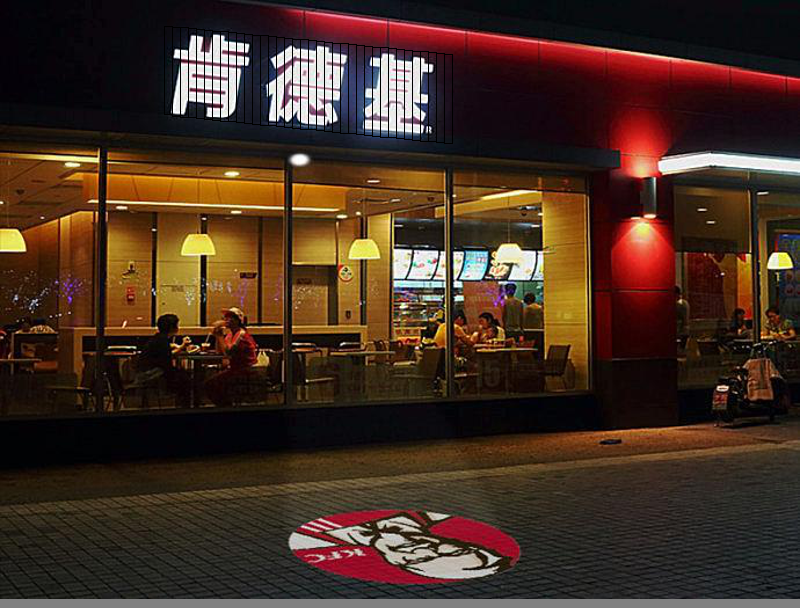

In [14]:
b

In [13]:
anchors = cluster.anchors
#anchors = '8,9, 8,18, 8,31, 8,59, 8,124, 8,351, 8,509, 8,605, 8,800'
anchors = [float(x) for x in anchors.split(',')]
anchors = np.array(anchors).reshape(-1, 2)
num_anchors = len(anchors)
class_names = ['none','text',]##text 
num_classes = len(class_names)
textModel = yolo_text(num_classes,anchors,train=True)
#textModel.load_weights('models/text.h5')##加载预训练模型权重


In [14]:
textModel.load_weights('/home/zzf/ocr/train/chineseocr/models/text.h5')##加载预训练模型权重

In [15]:
trainLoad = data_generator(jpgPath[:num_train], anchors, num_classes,splitW)
testLoad  = data_generator(jpgPath[num_train:], anchors, num_classes,splitW)


In [16]:
adam = tf.keras.optimizers.Adam(lr=0.0005)
textModel.compile(optimizer=adam, loss={'xy_loss':lambda y_true, y_pred:y_pred,
                                        'wh_loss':lambda y_true, y_pred:y_pred,
                                        'confidence_loss':lambda y_true, y_pred:y_pred,
                                        'class_loss':lambda y_true, y_pred:y_pred,
                                   }
                                    )


In [ ]:
textModel.fit_generator(generator=trainLoad, 
                         steps_per_epoch=num_train, 
                         epochs=5,
                         verbose=2, 
                         callbacks=None,
                         validation_data=testLoad, 
                         validation_steps=num_val)

Epoch 1/5


In [72]:
textModel.save('./train/text/tmp/textModel.h5')

In [5]:
from text.keras_yolo3 import yolo_text,box_layer,K
from config import kerasTextModel,IMGSIZE,keras_anchors,class_names
from apphelper.image import resize_im,letterbox_image
from PIL import Image
import numpy as np
import tensorflow as tf
graph = tf.get_default_graph()##解决web.py 相关报错问题

anchors = [float(x) for x in keras_anchors.split(',')]
anchors = np.array(anchors).reshape(-1, 2)
num_anchors = len(anchors)

num_classes = len(class_names)
textModelTest = yolo_text(num_classes,anchors)
kerasTextModel = '/home/zzf/ocr/train/chineseocr/t_model/textModel.h5'
textModelTest.load_weights(kerasTextModel)


sess = K.get_session()
image_shape = K.placeholder(shape=(2, ))##图像原尺寸:h,w
input_shape = K.placeholder(shape=(2, ))##图像resize尺寸:h,w
box_score = box_layer([*textModelTest.output,image_shape,input_shape],anchors, num_classes)



def text_detect(img,prob = 0.05):
    im    = Image.fromarray(img)
    scale = IMGSIZE[0]
    w,h   = im.size
    w_,h_ = resize_im(w,h, scale=scale, max_scale=2048)##短边固定为608,长边max_scale<4000
    #boxed_image,f = letterbox_image(im, (w_,h_))
    boxed_image = im.resize((w_,h_), Image.BICUBIC)
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    imgShape   = np.array([[h,w]])
    inputShape = np.array([[h_,w_]])
    
    
    global graph
    with graph.as_default():
         ##定义 graph变量 解决web.py 相关报错问题
         """
         pred = textModel.predict_on_batch([image_data,imgShape,inputShape])
         box,scores = pred[:,:4],pred[:,-1]
         
         """
         box,scores = sess.run(
            [box_score],
            feed_dict={
                textModelTest.input: image_data,
                input_shape: [h_, w_],
                image_shape: [h, w],
                K.learning_phase(): 0
            })[0]
        

    keep = np.where(scores>prob)
    
    box[:, 0:4][box[:, 0:4]<0] = 0
    box[:, 0][box[:, 0]>=w] = w-1
    box[:, 1][box[:, 1]>=h] = h-1
    box[:, 2][box[:, 2]>=w] = w-1
    box[:, 3][box[:, 3]>=h] = h-1
    box = box[keep[0]]

    scores = scores[keep[0]]
    return box,scores


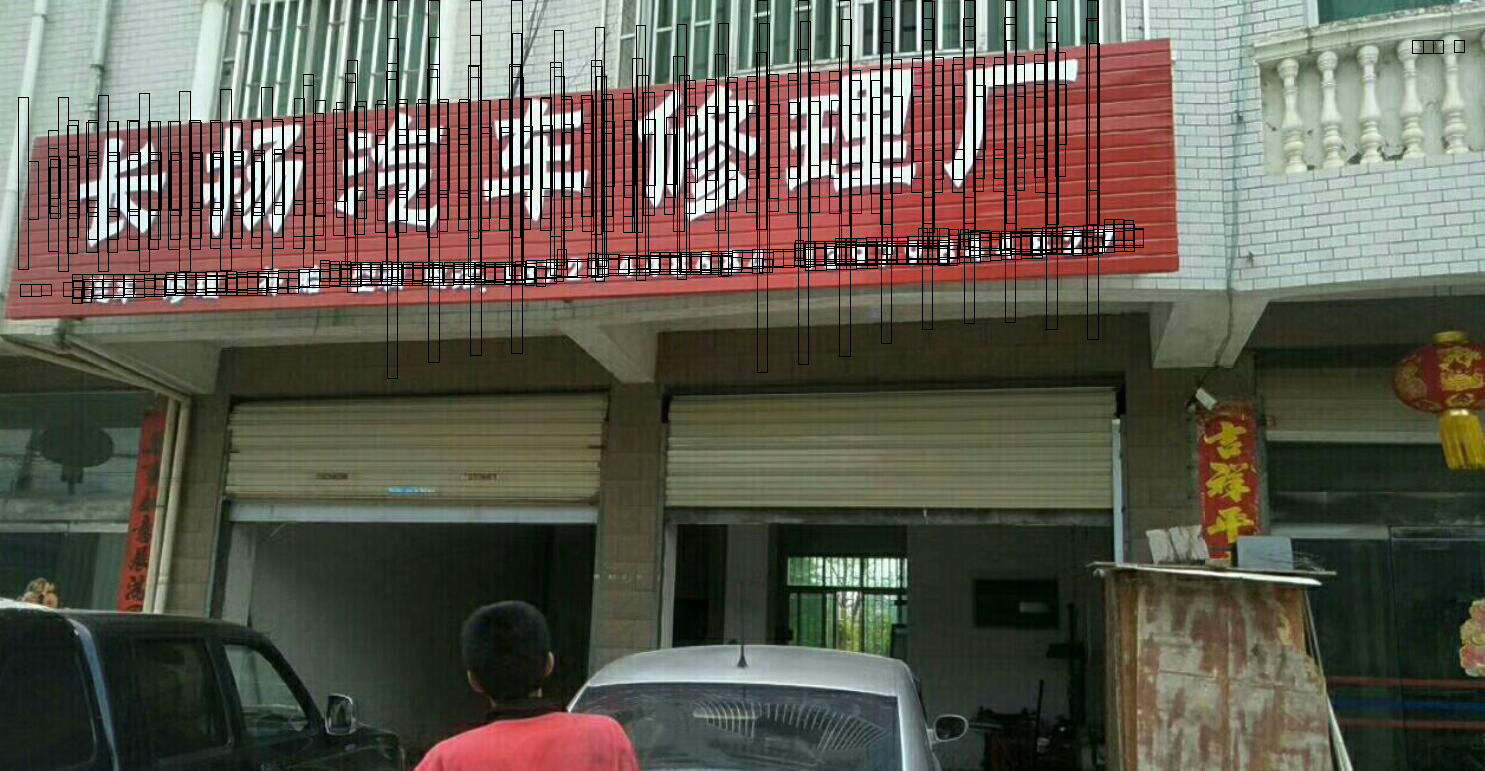

In [16]:
p='./train/data/text/t/5.jpg'
IMGSIZE=608,608
img = np.array(Image.open(p))
box,scores = text_detect(img,prob = 0.01)
plot_box(img,box)